<h1> Study of Teen SNS Data Using K Means Clustering </h1>

<p> Social Networking Sites (SNS) are a large repository of everyday interactions. Teenage demographics are known to be active on these sites. As such, this data can be useful to marketers. Finding target consumer archetypes within these demographics allows for better use of marketing resources. Clustering should achieve this result and offer insights into these demographics. </p>

<h3> Dataset Information </h3>

<p> The dataset includes numerical data of 30,000 high school students in the U.S. The numbers are counts of how often each word appears in their SNS activity. These words include common activities associated with various behaviors and market demographics. 

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv("snsdata.csv")

<h2> Data Summary </h2>

In [3]:
df.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,cute,sex,sexy,hot,kissed,dance,band,marching,music,rock,god,church,jesus,bible,hair,dress,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,2,1,0,0,0,6,4,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5,1,1,0,3,0,1,0,0,0,1,0,0,0,2,0,0,0,0,0,1,1


In [4]:
df.describe()

,gradyear,age,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,cute,sex,sexy,hot,kissed,dance,band,marching,music,rock,god,church,jesus,bible,hair,dress,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
count,30000.000000,24914.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,2007.500000,17.993950,30.179467,0.267333,0.252300,0.222767,0.161200,0.143133,0.13440,0.106633,0.104933,0.087333,0.139967,0.322867,0.209400,0.141200,0.126600,0.103200,0.425167,0.299600,0.040600,0.737833,0.243333,0.465300,0.248167,0.112067,0.021333,0.422567,0.110967,0.098933,0.257367,0.353000,0.14850,0.069867,0.051167,0.184100,0.114233,0.087967,0.060433
std,1.118053,7.858054,36.530877,0.804708,0.705357,0.917226,0.739707,0.639943,0.51699,0.514333,0.521726,0.516961,0.471080,0.802441,1.123504,0.528209,0.479145,0.509338,1.162574,1.118786,0.287091,1.252366,0.720375,1.343226,0.834028,0.581709,0.204645,1.097958,0.449436,1.942319,0.695758,0.724391,0.47264,0.346779,0.279555,0.624516,0.436796,0.399125,0.345522
min,2006.000000,3.086000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2006.750000,16.312000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2007.500000,17.287000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2008.250000,18.259000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2009.000000,106.927000,830.000000,24.000000,15.000000,27.000000,17.000000,14.000000,31.00000,9.000000,16.000000,15.000000,12.000000,18.000000,114.000000,18.000000,10.000000,26.000000,30.000000,66.000000,11.000000,64.000000,21.000000,79.000000,44.000000,30.000000,11.000000,37.000000,9.000000,327.000000,12.000000,11.000000,8.00000,9.000000,8.000000,22.000000,14.000000,8.000000,16.000000


22710.368860108163 0.0


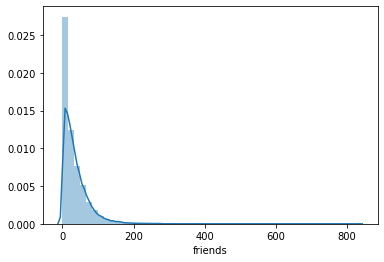

In [7]:
k2, p = stats.normaltest(df.friends)
print(k2, p)
sb.distplot(df.friends)

<p> Scipy's normaltest tests for skewness and kurtosis to find if a distribution is normal. With a p-value of 0, I reject the null hypothesis that 'friends' has a normal distribution. By examining a distribution plot, I can see that this assessment is correct with a heavy positive skew and heavy tail. </p>

friends 22710.368860108163 0.0


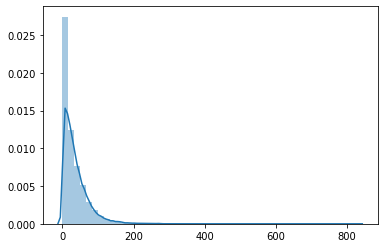

basketball 35327.97990390386 0.0


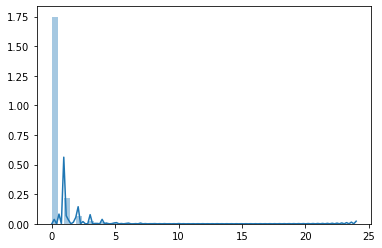

football 28111.803099656623 0.0


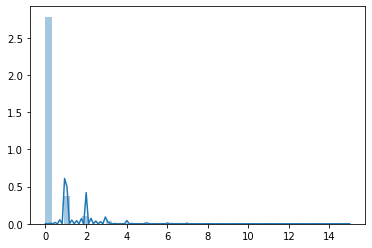

soccer 40772.54395190608 0.0


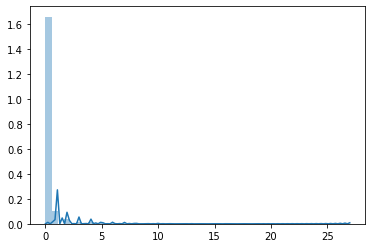

softball 40000.54469912166 0.0


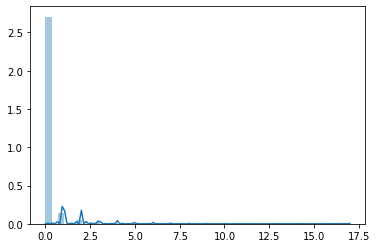

volleyball 39564.52485657644 0.0


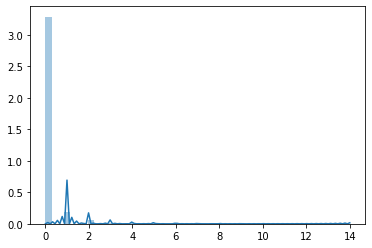

swimming 53431.54729925369 0.0


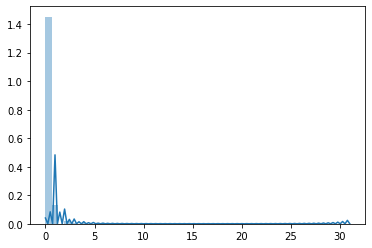

cheerleading 37512.04125078547 0.0


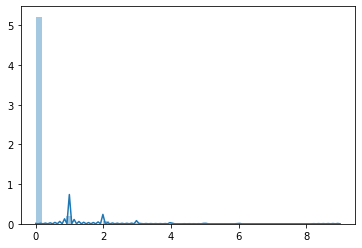

baseball 45112.320177869624 0.0


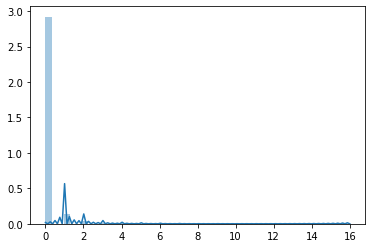

tennis 47854.84536569412 0.0


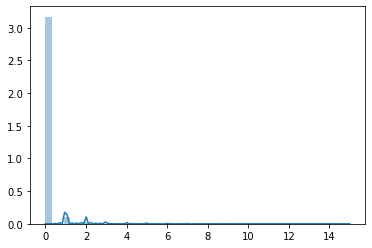

sports 34804.59652220463 0.0


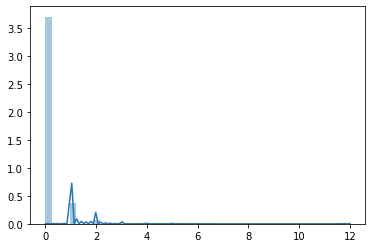

cute 27854.48272541404 0.0


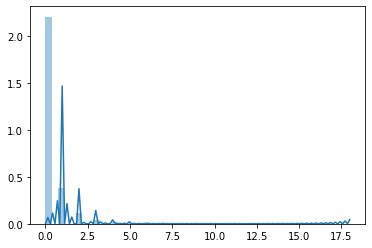

sex 88564.58770883703 0.0


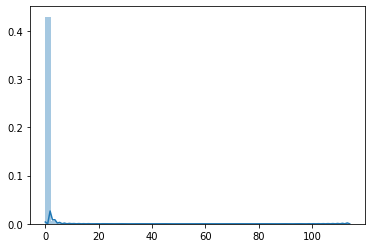

sexy 40519.106310002986 0.0


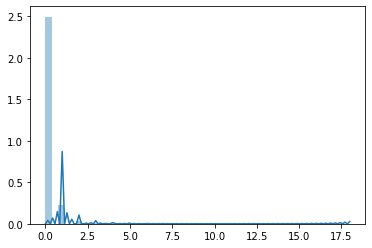

hot 33364.58848019334 0.0


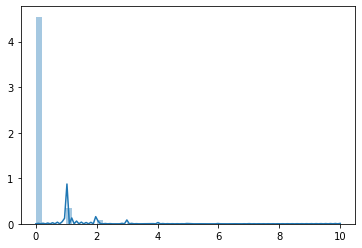

kissed 49027.33302021401 0.0


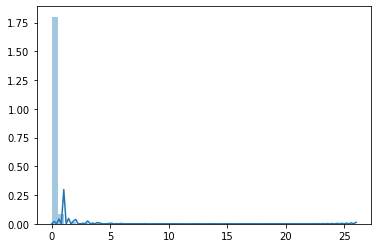

dance 35831.1598673402 0.0


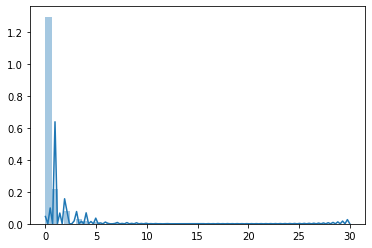

band 55287.541082152486 0.0


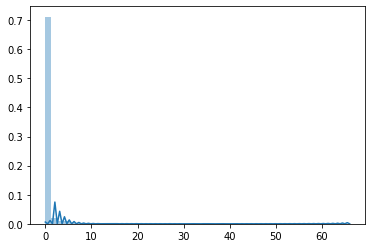

marching 51225.88746399722 0.0


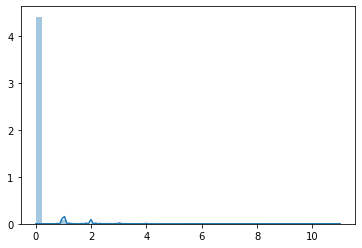

In [0]:
columns = df.columns[3:]

for column in columns:
  data = np.array(df[column].values).astype(np.float)
  k2, p = stats.normaltest(data)
  print(column, k2, p)
  sb.distplot(data)
  plt.show()

<p> Due to having all non-Gaussian distributions in the data, a StandardScaler may prove ineffective. The data will be centered around 0, but in many cases there is a heavy positive skew. In this case, the values will mostly be similar negative numbers which won't inform the model. However, I will compare later to normalized data to see what achieves better results. </p>

In [0]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.sum().sort_values()

bible               640.000
marching           1218.000
abercrombie        1535.000
drugs              1813.000
hollister          2096.000
tennis             2620.000
drunk              2639.000
blonde             2968.000
kissed             3096.000
baseball           3148.000
cheerleading       3199.000
dress              3329.000
jesus              3362.000
death              3427.000
hot                3798.000
swimming           4032.000
sports             4199.000
sexy               4236.000
volleyball         4294.000
clothes            4455.000
softball           4836.000
die                5523.000
sex                6282.000
soccer             6683.000
rock               7300.000
church             7445.000
football           7569.000
mall               7721.000
basketball         8020.000
band               8988.000
cute               9686.000
shopping          10590.000
hair              12677.000
dance             12755.000
god               13959.000
music             22

In [0]:
df.isnull().sum()

gradyear           0
gender          2724
age             5086
friends            0
basketball         0
football           0
soccer             0
softball           0
volleyball         0
swimming           0
cheerleading       0
baseball           0
tennis             0
sports             0
cute               0
sex                0
sexy               0
hot                0
kissed             0
dance              0
band               0
marching           0
music              0
rock               0
god                0
church             0
jesus              0
bible              0
hair               0
dress              0
blonde             0
mall               0
shopping           0
clothes            0
hollister          0
abercrombie        0
die                0
death              0
drunk              0
drugs              0
dtype: int64

In [0]:
df.gender.value_counts()

F    22054
M     5222
Name: gender, dtype: int64

<p> There is a clear imbalance in the male to female ratio in our dataset. </p>

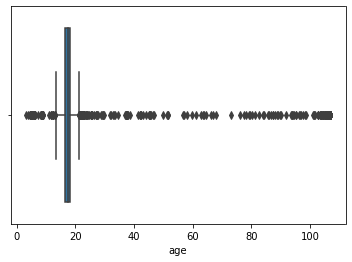

In [0]:
sb.boxplot(df.age)

<p> There are many outliers in age. Judging by the data, some recently graduated high school students were included, but no one older than 22 should be in this data. It is also unlikely any entry should be below 13.

In [0]:
df.groupby('gradyear')['age'].mean()

gradyear
2006   19.137
2007   18.391
2008   17.524
2009   16.876
Name: age, dtype: float64

<h2> Preparing the Data </h2>

In [0]:
q1 = df.age.quantile(0.25)
q3 = df.age.quantile(0.75)
iqr = q3-q1
df.age = np.where((df.age > (q3 + 1.5*iqr)), np.NaN, df.age)
df.age = np.where((df.age < (q1 - 1.5*iqr)), np.NaN, df.age)

<p> I remove the ages of outliers. I want to retain their SNS data but I don't want the mean age skewed by their entries </p>

In [0]:
df.age = df.groupby('gradyear').transform(lambda x: x.fillna(x.mean()))

In [0]:
df.groupby('gradyear')['age'].mean()

gradyear
2006   18.668
2007   17.711
2008   16.781
2009   15.826
Name: age, dtype: float64

<p> Here I can see that the mean for each gradyear has been reduced by approximately 1. This adjustment is expected from removal of outliers. </p>

In [0]:
df.age.describe()

count   30000.000
mean       17.247
std         1.151
min        13.396
25%        16.285
50%        17.243
75%        18.218
max        21.158
Name: age, dtype: float64

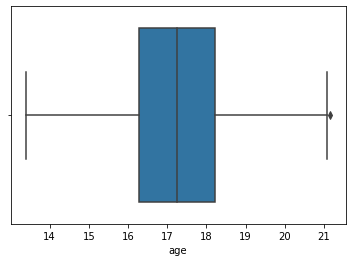

In [0]:
sb.boxplot(df.age)

In [0]:
genders = pd.get_dummies(df.gender)
df = pd.concat([df, genders], axis=1)
df = df.drop(['gender'], axis=1)

In [0]:
df.isnull().sum()

gradyear        0
age             0
friends         0
basketball      0
football        0
soccer          0
softball        0
volleyball      0
swimming        0
cheerleading    0
baseball        0
tennis          0
sports          0
cute            0
sex             0
sexy            0
hot             0
kissed          0
dance           0
band            0
marching        0
music           0
rock            0
god             0
church          0
jesus           0
bible           0
hair            0
dress           0
blonde          0
mall            0
shopping        0
clothes         0
hollister       0
abercrombie     0
die             0
death           0
drunk           0
drugs           0
F               0
M               0
dtype: int64

<p> There are no longer any null values. </p>

<p> There is likely high multicolinearity between gradyear and age. It may be beneficial to remove one of these columns to avoid noise in the model. </p>

In [0]:
covariance = np.cov(df.gradyear, df.age)
print(covariance)

[[ 1.25004167 -1.18216544]
 [-1.18216544  1.32459148]]


<p> It appears there is a negative covariance on age to gradyear (column 2, row 1) and on gradyear to age (column 1, row 2). This makes sense as those who graduate sooner are older.</p>

In [0]:
correlation = stats.pearsonr(df.gradyear, df.age)[0]
print(f'Pearsons correlation: {correlation}')

Pearsons correlation: -0.9187027930011035


<p> With a Pearson Correlation I can see more clearly a strong negative relationship. It is unclear from this correlation score alone whether they are correlated enough to remove one column from the data. </p>

In [7]:
variables = df.columns[3:39] # I standardize the SNS data but set aside age, gender, and friends.
features = df[variables].copy()
print(variables)

Index(['basketball', 'football', 'soccer', 'softball', 'volleyball',
       'swimming', 'cheerleading', 'baseball', 'tennis', 'sports', 'cute',
       'sex', 'sexy', 'hot', 'kissed', 'dance', 'band', 'marching', 'music',
       'rock', 'god', 'church', 'jesus', 'bible', 'hair', 'dress', 'blonde',
       'mall', 'shopping', 'clothes', 'hollister', 'abercrombie', 'die',
       'death', 'drunk', 'drugs'],
      dtype='object')


In [0]:
scaler = StandardScaler().fit(features.values)

In [0]:
scaled_features = scaler.transform(features.values)

In [10]:
scaled_df = df.copy()
scaled_df[variables] = scaled_features
scaled_df.head()

,gradyear,age,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,cute,sex,sexy,hot,kissed,dance,band,marching,music,rock,god,church,jesus,bible,hair,dress,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs,F,M
0,2006,18.982,7,-0.332217,-0.357697,-0.242874,-0.217928,-0.22367,-0.259971,-0.207327,-0.201131,-0.168939,-0.297123,-0.402362,-0.186384,-0.267323,-0.264225,-0.202619,0.494457,-0.267795,-0.141421,-0.589161,-0.337793,-0.346411,-0.297557,-0.192654,-0.104247,-0.384873,-0.246906,-0.050937,-0.369915,-0.487314,-0.314198,-0.201476,-0.183032,-0.294793,-0.261530,-0.220403,-0.174908,0,1
1,2006,18.801,0,-0.332217,1.060049,-0.242874,-0.217928,-0.22367,-0.259971,-0.207327,-0.201131,-0.168939,-0.297123,0.843856,-0.186384,-0.267323,-0.264225,-0.202619,-0.365718,-0.267795,-0.141421,1.007842,2.438587,0.398078,-0.297557,-0.192654,-0.104247,5.079910,8.653277,-0.050937,1.067392,-0.487314,-0.314198,-0.201476,-0.183032,-0.294793,-0.261530,-0.220403,-0.174908,1,0
2,2006,18.335,69,-0.332217,1.060049,-0.242874,-0.217928,-0.22367,-0.259971,-0.207327,-0.201131,-0.168939,-0.297123,-0.402362,-0.186384,-0.267323,-0.264225,-0.202619,-0.365718,1.519887,-0.141421,0.209341,-0.337793,-0.346411,-0.297557,-0.192654,-0.104247,-0.384873,-0.246906,-0.050937,-0.369915,-0.487314,-0.314198,-0.201476,-0.183032,-0.294793,2.027908,-0.220403,-0.174908,0,1
3,2006,18.875,0,-0.332217,-0.357697,-0.242874,-0.217928,-0.22367,-0.259971,-0.207327,-0.201131,-0.168939,-0.297123,0.843856,-0.186384,-0.267323,-0.264225,-0.202619,-0.365718,-0.267795,-0.141421,-0.589161,1.050397,-0.346411,-0.297557,-0.192654,-0.104247,-0.384873,-0.246906,-0.050937,-0.369915,-0.487314,-0.314198,-0.201476,-0.183032,-0.294793,-0.261530,-0.220403,-0.174908,1,0
4,2006,18.995,10,-0.332217,-0.357697,-0.242874,-0.217928,-0.22367,-0.259971,-0.207327,-0.201131,-0.168939,-0.297123,-0.402362,0.703703,-0.267323,-0.264225,9.614211,0.494457,0.626046,-0.141421,1.806344,-0.337793,0.398078,-0.297557,-0.192654,-0.104247,0.525925,-0.246906,-0.050937,-0.369915,2.273673,-0.314198,-0.201476,-0.183032,-0.294793,-0.261530,2.285122,2.719316,0,0


<p> So as to control for the effects of over-represented columns, I apply the common practice of standardizing the scale of the numerical data. This z-score standardization gives the model better comparative values between students. A value that is relatively high in the same column will have an appropriate effect even if the original numbers of that column were much lower than other columns. 

For example, drugs originally had only 1,813 entries whereas rock had 7,300 entries. Rock would dominate the model in comparison, but with standardized scores any entry of drugs could be found relatively important by the model.</p>

In [0]:
scaled_df.drop(['gradyear'], axis=1, inplace=True)

<p> To avoid multicolinearity, I should drop either gradyear or age. After removing outliers from age, it appears that it has standard, normal values which vary similarly to gradyear. I choose to keep it and drop gradyear so as to preserve potentially useful variance in student ages. </p>

<h2> Model One: Iterating and Plotting for the Elbow Method </h2>

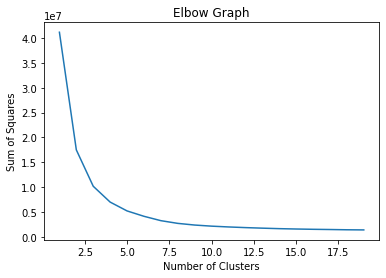

In [0]:
sum_of_squares = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300,
                    n_init=10, random_state=0)
    kmeans.fit(scaled_df)
    sum_of_squares.append(kmeans.inertia_)
plt.plot(range(1,20), sum_of_squares)
plt.title('Elbow Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squares')
plt.show()

<p> The sum of squares appears to be nearly linear after 5 clusters. This suggests 5 is an appropriate number of clusters. </p>

In [35]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(scaled_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [36]:
df['cluster'] = kmeans.labels_
df.head()

,gradyear,age,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,cute,sex,sexy,hot,kissed,dance,band,marching,music,rock,god,church,jesus,bible,hair,dress,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs,F,M,cluster
0,2006,18.982,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
1,2006,18.801,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,2,1,0,0,0,6,4,0,1,0,0,0,0,0,0,0,0,1,0,3
2,2006,18.335,69,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,2006,18.875,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3
4,2006,18.995,10,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5,1,1,0,3,0,1,0,0,0,1,0,0,0,2,0,0,0,0,0,1,1,0,0,3


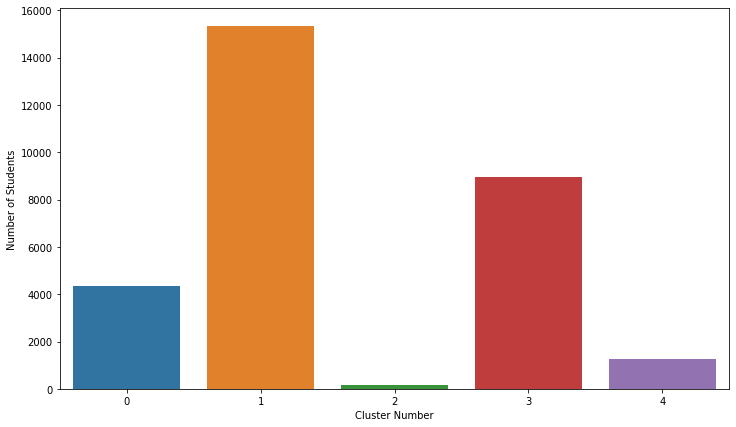

In [0]:
plt.figure(figsize=(12,7))
axis = sb.barplot(x=np.arange(0,5,1), y=df.groupby(['cluster']).count()['age'].values)
x = axis.set_xlabel("Cluster Number")
x = axis.set_ylabel("Number of Students")

In [0]:
cluster_size = list(df.groupby(['cluster']).count()['gradyear'].values)
cluster_size

[4329, 15324, 153, 8955, 1239]

In [0]:
means = df.groupby(['cluster']).mean()
df.groupby(['cluster']).mean() # This line is for interactive python display.

,gradyear,age,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,cute,sex,sexy,hot,kissed,dance,band,marching,music,rock,god,church,jesus,bible,hair,dress,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs,F,M
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2007.623,17.123,70.467,0.331,0.286,0.271,0.237,0.180,0.155,0.141,0.128,0.092,0.152,0.399,0.181,0.161,0.149,0.114,0.504,0.313,0.044,0.778,0.274,0.560,0.337,0.145,0.024,0.455,0.129,0.108,0.319,0.448,0.172,0.096,0.078,0.174,0.122,0.091,0.059,0.782,0.133
1,2007.438,17.309,6.146,0.225,0.230,0.193,0.121,0.111,0.116,0.087,0.092,0.081,0.127,0.274,0.207,0.129,0.108,0.095,0.369,0.273,0.036,0.686,0.222,0.415,0.204,0.095,0.019,0.395,0.095,0.080,0.221,0.298,0.135,0.055,0.040,0.179,0.101,0.084,0.064,0.704,0.193
2,2007.693,17.057,258.118,0.320,0.275,0.275,0.209,0.216,0.229,0.157,0.144,0.098,0.137,0.438,0.229,0.170,0.144,0.176,0.464,0.379,0.065,0.706,0.209,0.660,0.242,0.085,0.007,0.667,0.190,0.124,0.314,0.582,0.209,0.124,0.157,0.229,0.150,0.137,0.059,0.850,0.085
3,2007.517,17.228,34.344,0.292,0.268,0.246,0.179,0.172,0.153,0.110,0.111,0.094,0.156,0.345,0.224,0.144,0.136,0.109,0.464,0.338,0.047,0.802,0.264,0.481,0.262,0.120,0.022,0.437,0.121,0.121,0.265,0.378,0.157,0.072,0.050,0.194,0.129,0.088,0.057,0.752,0.175
4,2007.688,17.066,128.418,0.385,0.292,0.244,0.255,0.203,0.148,0.203,0.134,0.096,0.140,0.479,0.229,0.196,0.203,0.115,0.560,0.290,0.041,0.781,0.257,0.629,0.379,0.157,0.031,0.517,0.156,0.134,0.434,0.487,0.164,0.135,0.092,0.207,0.140,0.119,0.048,0.819,0.094


In [37]:
def max_and_min_to_dict(df):
  ''' Return lists for each cluster containing the features in which it has the highest and lowest means. 
      This gives an idea of how to interpret each cluster.'''
  max_min = {}
  for i in range(5):
    max_min[f"{i}_maximum"] = []
    max_min[f"{i}_minimum"] = []

  for i in df.columns:
    max_clust = np.argmax(df.groupby(['cluster'])[i].mean())
    max_min[f"{max_clust}_maximum"].append(i)
    min_clust = np.argmin(df.groupby(['cluster'])[i].mean())
    max_min[f"{min_clust}_minimum"].append(i)

  return max_min

print(max_and_min_to_dict(df))

{'0_maximum': ['rock'], '0_minimum': ['sex', 'die', 'cluster'], '1_maximum': ['sports', 'music'], '1_minimum': [], '2_maximum': ['basketball', 'football', 'softball', 'cheerleading', 'cute', 'sex', 'sexy', 'hot', 'dance', 'church', 'jesus', 'bible', 'blonde', 'mall', 'hollister'], '2_minimum': ['drugs'], '3_maximum': ['age', 'drugs', 'M'], '3_minimum': ['gradyear', 'friends', 'basketball', 'football', 'soccer', 'softball', 'volleyball', 'swimming', 'cheerleading', 'baseball', 'tennis', 'sports', 'cute', 'sexy', 'hot', 'kissed', 'dance', 'band', 'marching', 'music', 'god', 'church', 'hair', 'dress', 'blonde', 'mall', 'shopping', 'clothes', 'hollister', 'abercrombie', 'death', 'drunk', 'F'], '4_maximum': ['gradyear', 'friends', 'soccer', 'volleyball', 'swimming', 'baseball', 'tennis', 'kissed', 'band', 'marching', 'god', 'hair', 'dress', 'shopping', 'clothes', 'abercrombie', 'die', 'death', 'drunk', 'F', 'cluster'], '4_minimum': ['age', 'rock', 'jesus', 'bible', 'M']}


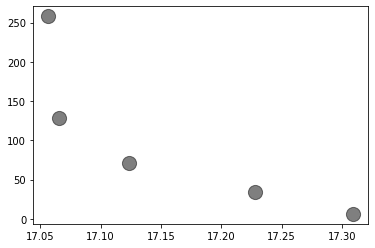

In [0]:
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

<p> There is a visible distance between the clusters as expected. </p>

In [0]:
sum_of_squares = {}
scores = {}
for i in range (2,12):
  model = KMeans(n_clusters = i, init='k-means++', max_iter=300,
                    n_init=10, random_state=0)
  predictions = model.fit_predict(scaled_df)
  centers = model.cluster_centers_

  sum_of_squares[i] = model.inertia_
  scores[i] = silhouette_score(scaled_df, predictions)
print("Within Cluster Sum of Squares:", *sum_of_squares.items(), sep="\n")
print("Silhouette Scores:", *scores.items(), sep="\n")

Within Cluster Sum of Squares:
(2, 17499631.728454974)
(3, 10182418.907387014)
(4, 6998049.1204255475)
(5, 5221562.509909969)
(6, 4139196.6118674516)
(7, 3261192.5059103076)
(8, 2715511.804523202)
(9, 2379682.533650881)
(10, 2157584.8147818586)
(11, 1997443.2837439734)
Silhouette Scores:
(2, 0.6402894592887031)
(3, 0.579687474382945)
(4, 0.5286732985067059)
(5, 0.5153917757868709)
(6, 0.4946489500938431)
(7, 0.4667878549564446)
(8, 0.44786172474695)
(9, 0.40869474459870114)
(10, 0.38247488335629015)
(11, 0.3831122000735432)


<p> The clusters I found are believable, but I want to also consider the silhouette score. The formula for silhouette score maximizes distance between clusters and minimizes distance between points within a cluster. I want to maximize silhouette score while minimizing the sum of squared errors. In this case, as my number of clusters increases my silhouette score decreases. It appears that my clusters are getting crowded and/or noisy. </p>

<h2> Model Two With Only SNS Data </h2>

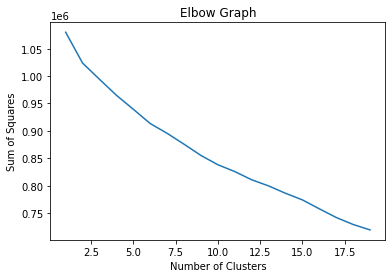

In [16]:
sum_of_squares = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300,
                    n_init=10, random_state=0)
    kmeans.fit(scaled_features)
    sum_of_squares.append(kmeans.inertia_)
plt.plot(range(1,20), sum_of_squares)
plt.title('Elbow Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squares')
plt.show()

<p> For the sake of achieving better clusters, I try to cluster based only on the SNS features. Gender, age, and friends are disregarded in this method. I find that there is no clear elbow. </p>

In [17]:
sum_of_squares = {}
scores = {}
for i in range (2,12):
  model = KMeans(n_clusters = i, init='k-means++', max_iter=300,
                    n_init=10, random_state=0)
  predictions = model.fit_predict(scaled_features)
  centers = model.cluster_centers_

  sum_of_squares[i] = model.inertia_
  scores[i] = silhouette_score(scaled_features, predictions)
print("Within Cluster Sum of Squares:", *sum_of_squares.items(), sep="\n")
print("Silhouette Scores:", *scores.items(), sep="\n")

Within Cluster Sum of Squares:
(2, 1023757.2554533876)
(3, 994114.3213280775)
(4, 965031.1810732435)
(5, 939454.1593458481)
(6, 913395.5036594466)
(7, 895549.1321919467)
(8, 875671.6314362204)
(9, 855167.3914093846)
(10, 838223.7621863837)
(11, 825761.1664063677)
Silhouette Scores:
(2, 0.4232240016388421)
(3, 0.3255123760131201)
(4, 0.32582781821952633)
(5, 0.310569052857367)
(6, 0.30456531429643924)
(7, 0.29023366528361183)
(8, 0.26901719829966547)
(9, 0.2546986424243994)
(10, 0.24859555646243855)
(11, 0.2527628980767327)


<p> The silhouette score is worse across cluster counts from 2 to 11, suggesting that it's harder to differentiate between clusters without the number of friends, gender, and age. However, the sum of squares is lower now. Considering both formulae, this suggests that the clusters are denser but closer together. </p>

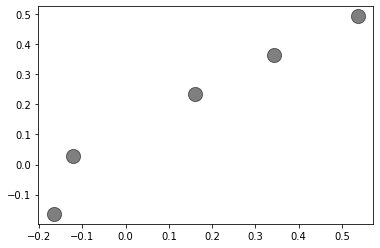

In [0]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(features)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

<p> The important detail in this graph is the change in scale. The y-axis scaled to 250 before removing age, friends, and gender. Now it only scales to 2.5. This is likely due to age and friends being on a significantly different scale from the other numbers, which were standardized. </p>

In [0]:
new_scaled = scaled_df.copy()
new_scaled['cluster'] = kmeans.labels_
new_scaled.head()

,age,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,cute,sex,sexy,hot,kissed,dance,band,marching,music,rock,god,church,jesus,bible,hair,dress,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs,F,M,cluster
0,18.982,7,-0.332,-0.358,-0.243,-0.218,-0.224,-0.260,-0.207,-0.201,-0.169,-0.297,-0.402,-0.186,-0.267,-0.264,-0.203,0.494,-0.268,-0.141,-0.589,-0.338,-0.346,-0.298,-0.193,-0.104,-0.385,-0.247,-0.051,-0.370,-0.487,-0.314,-0.201,-0.183,-0.295,-0.262,-0.220,-0.175,0,1,1
1,18.801,0,-0.332,1.060,-0.243,-0.218,-0.224,-0.260,-0.207,-0.201,-0.169,-0.297,0.844,-0.186,-0.267,-0.264,-0.203,-0.366,-0.268,-0.141,1.008,2.439,0.398,-0.298,-0.193,-0.104,5.080,8.653,-0.051,1.067,-0.487,-0.314,-0.201,-0.183,-0.295,-0.262,-0.220,-0.175,1,0,2
2,18.335,69,-0.332,1.060,-0.243,-0.218,-0.224,-0.260,-0.207,-0.201,-0.169,-0.297,-0.402,-0.186,-0.267,-0.264,-0.203,-0.366,1.520,-0.141,0.209,-0.338,-0.346,-0.298,-0.193,-0.104,-0.385,-0.247,-0.051,-0.370,-0.487,-0.314,-0.201,-0.183,-0.295,2.028,-0.220,-0.175,0,1,1
3,18.875,0,-0.332,-0.358,-0.243,-0.218,-0.224,-0.260,-0.207,-0.201,-0.169,-0.297,0.844,-0.186,-0.267,-0.264,-0.203,-0.366,-0.268,-0.141,-0.589,1.050,-0.346,-0.298,-0.193,-0.104,-0.385,-0.247,-0.051,-0.370,-0.487,-0.314,-0.201,-0.183,-0.295,-0.262,-0.220,-0.175,1,0,1
4,18.995,10,-0.332,-0.358,-0.243,-0.218,-0.224,-0.260,-0.207,-0.201,-0.169,-0.297,-0.402,0.704,-0.267,-0.264,9.614,0.494,0.626,-0.141,1.806,-0.338,0.398,-0.298,-0.193,-0.104,0.526,-0.247,-0.051,-0.370,2.274,-0.314,-0.201,-0.183,-0.295,-0.262,2.285,2.719,0,0,4


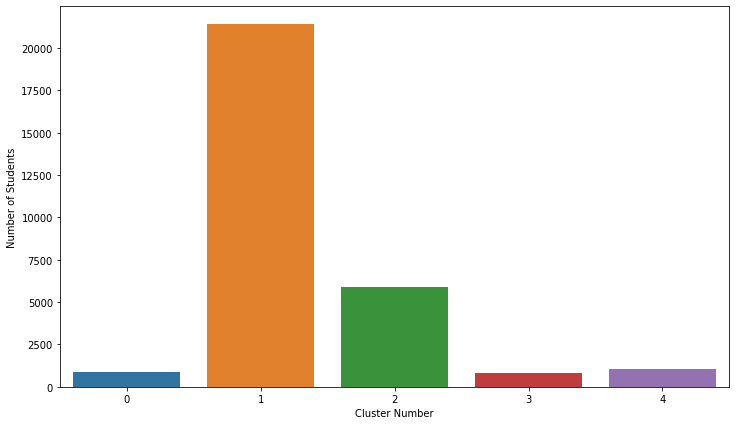

In [0]:
plt.figure(figsize=(12,7))
axis = sb.barplot(x=np.arange(0,5,1), y = new_scaled.groupby(['cluster']).count()['age'].values)
x = axis.set_xlabel("Cluster Number")
x = axis.set_ylabel("Number of Students")

<p> The clusters in this method are even more disparate. This suggests that age, gender, and friends carried useful explanatory power. </p>

<h2> Model Three: Gaussian Mixture Model of 5 Clusters </h2>

In [0]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=5, verbose=1, random_state=0).fit(scaled_df)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


<p> The Gaussian Mixture Model is often applied in instances where data is incomplete and there may be hidden variables. This may be such a case. For that reason I am applying it with the same number of clusters as my original model. </p>

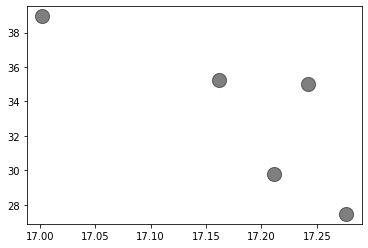

In [0]:
centers = gmm.means_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

<p> The overall distribution of the cluster centers looks similar to what I achieved before. </p>

In [0]:
predictions = gmm.predict(scaled_df)
slhtt = silhouette_score(scaled_df, predictions)
print(slhtt)

0.009789303418326064


<p> The silhouette score is significantly lower than what I achieved on the first model. K-Means clustering appears to be the better model. </p>

<h2> Model Four: Normalized Data </h2>

This model is similar to the first, which performed best so far. However, the data is noramlized for this model instead of scaled. Additionally, the WCSS looked better without age, gender, and friends, but not the silhouette score. This may be due to the scale of friends, so I will try including and normalizing friends as well.

In [0]:
variables = df.columns[2:39] # I standardize the SNS data but set aside age, gender, and friends.
features = df[variables].copy()
normalizer = Normalizer().fit(features.values)
norm_features = normalizer.transform(features.values)

In [0]:
norm_df = df.copy()
norm_df[variables] = norm_features
norm_df.head()
norm_df.drop(['gradyear'], axis=1, inplace=True)

In [20]:
sum_of_squares = {}
scores = {}
for i in range (2,12):
  model = KMeans(n_clusters = i, init='k-means++', max_iter=300,
                    n_init=10, random_state=0)
  predictions = model.fit_predict(norm_df)
  centers = model.cluster_centers_

  sum_of_squares[i] = model.inertia_
  scores[i] = silhouette_score(norm_df, predictions)
print("Within Cluster Sum of Squares:", *sum_of_squares.items(), sep="\n")
print("Silhouette Scores:", *scores.items(), sep="\n")

Within Cluster Sum of Squares:
(2, 31587.810489729287)
(3, 26023.098413561296)
(4, 22210.937056351784)
(5, 19069.976243246576)
(6, 17651.313426401444)
(7, 16084.572175804142)
(8, 14811.057917529977)
(9, 13782.824782176349)
(10, 12912.097665325975)
(11, 12312.942186162953)
Silhouette Scores:
(2, 0.40545062188330727)
(3, 0.28840823065134963)
(4, 0.3108964632017744)
(5, 0.32632801222226504)
(6, 0.3257339206609511)
(7, 0.29645607601232027)
(8, 0.30421129584670187)
(9, 0.31548865311113755)
(10, 0.32674680639648446)
(11, 0.3348058725774745)


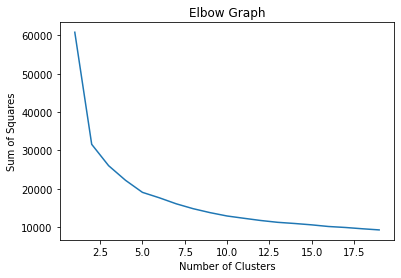

In [21]:
sum_of_squares = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300,
                    n_init=10, random_state=0)
    kmeans.fit(norm_df)
    sum_of_squares.append(kmeans.inertia_)
plt.plot(range(1,20), sum_of_squares)
plt.title('Elbow Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squares')
plt.show()

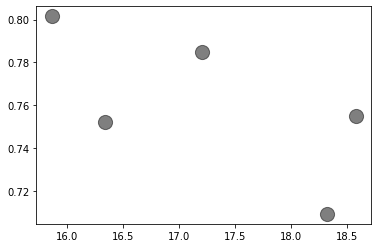

In [22]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(norm_df)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [25]:
norm_df['cluster'] = kmeans.labels_
norm_df.head()

,age,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,cute,sex,sexy,hot,kissed,dance,band,marching,music,rock,god,church,jesus,bible,hair,dress,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs,F,M,cluster
0,18.982,0.989949,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.141421,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,1,2
1,18.801,0.000000,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.250000,0.250000,0.125000,0.0,0.0,0.0,0.750000,0.5,0.0,0.125,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,0
2,18.335,0.999266,0.0,0.014482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.028964,0.0,0.014482,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.014482,0.000000,0.000000,0,1,2
3,18.875,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.707107,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1,0,0
4,18.995,0.830455,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.083045,0.0,0.0,0.415227,0.083045,0.083045,0.0,0.249136,0.000000,0.083045,0.0,0.0,0.0,0.083045,0.0,0.0,0.000,0.166091,0.0,0.0,0.0,0.0,0.000000,0.083045,0.083045,0,0,2


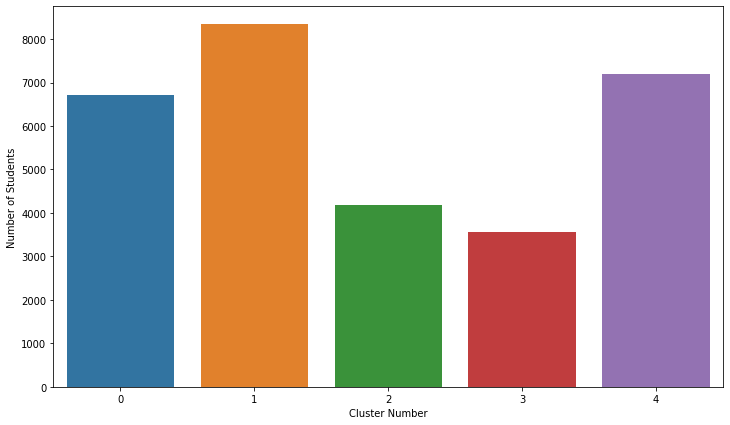

In [26]:
plt.figure(figsize=(12,7))
axis = sb.barplot(x=np.arange(0,5,1), y = norm_df.groupby(['cluster']).count()['age'].values)
x = axis.set_xlabel("Cluster Number")
x = axis.set_ylabel("Number of Students")

In [28]:
print(max_and_min_to_dict(norm_df))

{'0_maximum': ['age', 'cute', 'sex', 'music', 'god', 'jesus', 'bible', 'dress', 'shopping', 'death', 'drunk', 'drugs', 'F'], '0_minimum': ['basketball', 'soccer', 'sports', 'M', 'cluster'], '1_maximum': ['hot', 'kissed'], '1_minimum': ['jesus'], '2_maximum': ['tennis', 'band', 'marching', 'die', 'M'], '2_minimum': ['friends', 'softball', 'volleyball', 'cheerleading', 'cute', 'sexy', 'hot', 'kissed', 'dance', 'church', 'hair', 'blonde', 'mall', 'clothes', 'hollister', 'abercrombie', 'drugs', 'F'], '3_maximum': ['basketball', 'football', 'soccer', 'baseball', 'sports', 'rock'], '3_minimum': ['swimming', 'music', 'god', 'dress', 'shopping', 'death', 'drunk'], '4_maximum': ['friends', 'softball', 'volleyball', 'swimming', 'cheerleading', 'sexy', 'dance', 'church', 'hair', 'blonde', 'mall', 'clothes', 'hollister', 'abercrombie', 'cluster'], '4_minimum': ['age', 'football', 'baseball', 'tennis', 'sex', 'band', 'marching', 'rock', 'bible', 'die']}


<h2> Conclusion: 5 Cluster Model Including Personal Information </h2>

In conclusion, the model I would suggest using is the one that retains age, gender, and friends. I used K Means with normalized features. This results in a higher silhouette score and a clear elbow for selecting number of clusters. More clusters would reduce the WCSS but would also decrease the silhouette score, so there is a tradeoff.

Here are results from the means of each cluster. I've included that output in the next cell for ease of reference.

Cluster 1 is the largest with the highest means in hot and kissed and the lowest mean in jesus. Ideally, there would be more outstanding features in the largest cluster, but there could be a generic trend to this cluster.

Cluster 4 is the second largest with various extracurricular activities as their highest values. This cluster is surprising as the lowest means for many other extracurricular activities are also present here. This may represent some preference in some sports over others for a demographic. Also of interest is that sexy is represented here, but sex is at a minimum representation in this cluster. This is also the youngest group.

Cluster 0 is the oldest, has the highest mentions of sex and some religious categories. It is also the oldest group and has the lowest representation of males. Though, this may not be very informative for gender-based marketing due to the imbalanced dataset.

Cluster 2 has the most males along with marching and band. It has the lowest representation in many sports and fashion categories.

Cluster 3 is the smallest with several competitive sports. There are not obvious connotations to me in the categories least represented in cluster 3.

Overall, I would prefer to see clearer connections in each cluster, but the clusters are each of a similar size. The silhouette score and WCSS indicates that there is a good distance between clusters and that the clusters are dense. Therefore, I trust that the algorithm has returned a reliable model. Further market research into the represented categories should prove effective in interpreting these clusters.


In [29]:
from pprint import PrettyPrinter
print("Cluster maximum means and minimum means", "\n")
pp = PrettyPrinter(indent = 2)
pp.pprint(max_and_min_to_dict(norm_df))

Cluster maximum means and minimum means 

{ '0_maximum': [ 'age',
                 'cute',
                 'sex',
                 'music',
                 'god',
                 'jesus',
                 'bible',
                 'dress',
                 'shopping',
                 'death',
                 'drunk',
                 'drugs',
                 'F'],
  '0_minimum': ['basketball', 'soccer', 'sports', 'M', 'cluster'],
  '1_maximum': ['hot', 'kissed'],
  '1_minimum': ['jesus'],
  '2_maximum': ['tennis', 'band', 'marching', 'die', 'M'],
  '2_minimum': [ 'friends',
                 'softball',
                 'volleyball',
                 'cheerleading',
                 'cute',
                 'sexy',
                 'hot',
                 'kissed',
                 'dance',
                 'church',
                 'hair',
                 'blonde',
                 'mall',
                 'clothes',
                 'hollister',
                 'abercrombie',